# Comparaçao entre gradiente numerico e analitico

Nesse notebook estao sistematizados os testes para comparaç~ao entre diferenças finitas e a funç~ao analitica calculada para 

In [1]:
# Imports das bibliotecas e módulos usados

from Multicanal import *
from matplotlib import pyplot as plt
from numpy import linalg as lg
from scipy import fft as fft
import numpy as np

## Declaração das contantes e variáveis usadas ao longo do programa

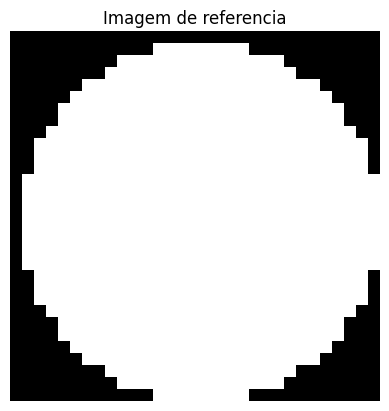

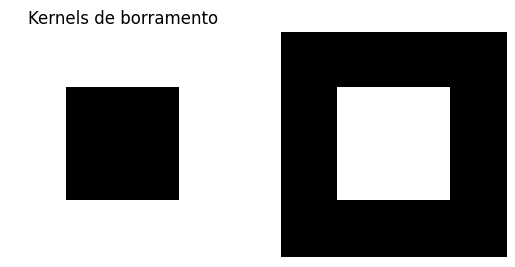

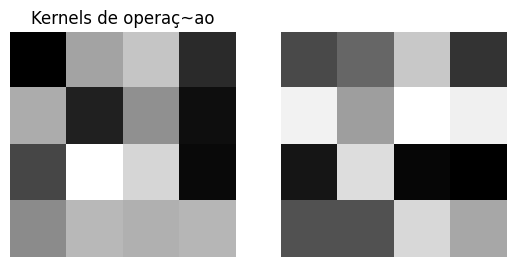

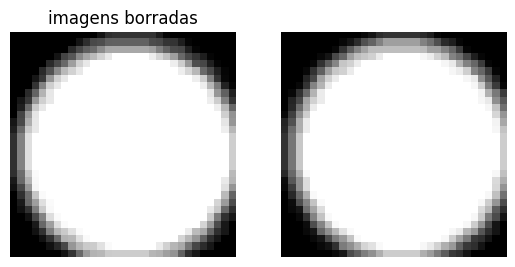

In [55]:
def gen_circ (r):
    '''Funç~ao de geraç~ao de matriz com
       circulo, para facilitar o proces-
       sa mento do teste. Retirado de:
       https://stackoverflow.com/questions/39073973/how-to-generate-a-matrix-with-circle-of-ones-in-numpy-scipy
       
       Relaç~ao de inputs:
        r - raio do c'irculo.'''

    d      = 2*r + 1
    rx, ry = d/2, d/2
    x, y   = np.indices((d, d))
    return (np.abs(np.hypot(rx - x, ry - y)) < r).astype(float)

# Determinaç~ao das matrizes usadas para ponto de operaç~ao
img    = gen_circ(15)
sx, sy = img.shape
n      = 2
sk     = 4

# Declaraç~ao das const's de regularizaç~ao
mu   = 1e-5
lbda = 1e-5 

# Geraç~ao dos kernels de borramento
ker          = np.zeros((4, 4, 2))
ker[:, :, 0] = np.array([
    [1, 1, 1, 1],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [1, 1, 1, 1]
])
ker[:, :, 0] /= ker[:, :, 0].sum().sum()
ker[:, :, 1]  = np.array([
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0]
])
ker[:, :, 1] /= ker[:, :, 1].sum().sum()

# Geraç~ao dos kernels para ponto de operaç~ao
ker_op = np.zeros((4, 4, 2))
ker_op[:, :, 0]  = np.array([
    [0.00432619, 0.56073908, 0.67914993, 0.14950353],
    [0.59215767, 0.11979369, 0.49662964, 0.05516508],
    [0.24583893, 0.87801624, 0.73582039, 0.03805045],
    [0.48026675, 0.63361043, 0.60828755, 0.62653676]
])
ker_op[:, :, 0] /= ker_op[:, :, 0].sum().sum()
ker_op[:, :, 1]  = np.array([
    [0.28137002, 0.3885972 , 0.75671795, 0.20035163],
    [0.91013721, 0.59792427, 0.9617708 , 0.90449515],
    [0.08687498, 0.83484564, 0.03296456, 0.00838778],
    [0.31106622, 0.31390819, 0.81356953, 0.63244295]
])
ker_op[:, :, 1] /= ker_op[:, :, 0].sum().sum()

# Preparaç~ao das imagens borradas
b_img          = np.zeros((sx, sy, 2))
b_img[:, :, 0] = signal.convolve2d(img, ker_op[:, :, 0], mode='same')
b_img[:, :, 1] = signal.convolve2d(img, ker_op[:, :, 1], mode='same')

# Plotagem das figuras
plt.imshow(img, cmap='gray')
plt.title('Imagem de referencia')
plt.axis('off')
plt.show()
plt.subplot(1, 2, 1)
plt.title('Kernels de borramento')
plt.imshow(ker[:, :, 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ker[:, :, 1], cmap='gray')
plt.axis('off')
plt.show()
plt.subplot(1, 2, 1)
plt.title('Kernels de operaç~ao')
plt.imshow(ker_op[:, :, 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ker_op[:, :, 1], cmap='gray')
plt.axis('off')
plt.show()
plt.subplot(1, 2, 1)
plt.title('imagens borradas')
plt.imshow(b_img[:, :, 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(b_img[:, :, 1], cmap='gray')
plt.axis('off')
plt.show()

## Teste de comparação entre $\nabla_{k_i} \mathcal{L}$ e $\Delta_{k_i} \mathcal{L}$

'E interessante perceber como 'e medida a correlaç~ao entre ambas as estruturas de gradiente

\begin{equation*}
    [\nabla_{k_i} \mathcal{L}]_{i,j} \approx \frac{\mathcal{L}(x, \vec{k} + \delta e_{i,j}, \vec{y}) - \mathcal{L}(x, \vec{k} - \delta e_{i,j}, \vec{y})}{2 \delta} \equiv [\Delta_{k_i} \mathcal{L}]_{i,j}
\end{equation*}

In [56]:
def central_dif (BIMG, KER_point, IM, sk, sx, sy, n, epsi=1e-5):
    # Declara tensores usados ao longo da função.
    Jac  = np.zeros((sx, sy, n), dtype=complex)
    pert = np.zeros((sk, sk, n))

    # Declaraç~ao de indice de fator
    idx = 0

    # VERIFICAR FORMA EFICIENTE DE COMPUTAR ISSO DAQUI!!
    # Laço de método das diferenças
    for ii in range(sk):
        for jj in range(sk):
            for kk in range(n):
                # Prepara matriz de perturbação
                pert             = np.zeros((sk, sk, n))
                pert[ii, jj, kk] = 1
                Pert[:, :, 0]    = epsi * fft.fft2(pert[:, :, 0], (sx, sy))
                Pert[:, :, 1]    = epsi * fft.fft2(pert[:, :, 1], (sx, sy))
    
                # Calcula as diferenças frontais e traseiras a partir de Pert
                F_dif = cost_fun(BIMG, KER_point + Pert, X=IM, mu=mu)
                B_dif = cost_fun(BIMG, KER_point - Pert, X=IM, mu=mu)
    
                # Estima gradiente numérico a partir da diferença numérica
                Jac[ii, jj, kk] = (F_dif - B_dif) / (2 * epsi)
    
                # Incrementa idx total
                idx += 1

    return Jac

# Declaraç~ao de param. de perturb.
eps_vec = [np.float_power(10, ii) for ii in np.arange(-10, 15)]

# Vetor Contendo razão de cada componente dos gradientes (numérico deve ser proporcional ao calculado)
factor = np.zeros((sx * sy * 2))

# Calcula as TF's das vari'aveis usadas
IM                 = fft.fft2(img)
BIMG               = np.zeros(b_img.shape, dtype=complex)
BIMG[:, :, 0]      = fft.fft2(b_img[:, :, 0]) 
BIMG[:, :, 1]      = fft.fft2(b_img[:, :, 1])
KER_point          = np.zeros(b_img.shape, dtype=complex)
KER_point[:, :, 0] = fft.fft2(ker[:, :, 0], (sx, sy)) 
KER_point[:, :, 1] = fft.fft2(ker[:, :, 1], (sx, sy))

# Gera gradiente calculado por função
Jac_calc = cost_fun_jac(BIMG, KER_point, X=IM)

# Declara matriz de perturbação
Pert     = np.zeros_like(KER_point)
Jac_num  = central_dif(BIMG, KER_point, IM, sk, sx, sy, n, epsi=eps_vec[0])

eps = 1e-10
diferença entre vetores p/ eps=1e-10: 0.842722697656826
alinhamento: 0.1572773023497732
grad numérico:  max = 0.2503141389731659, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


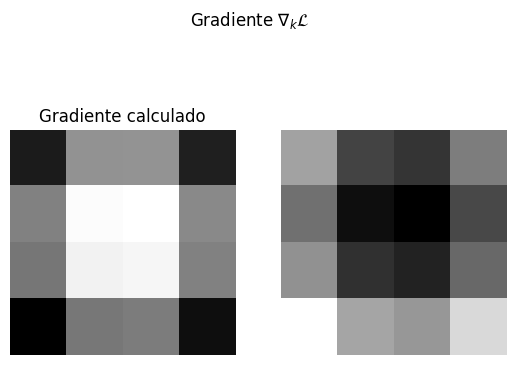

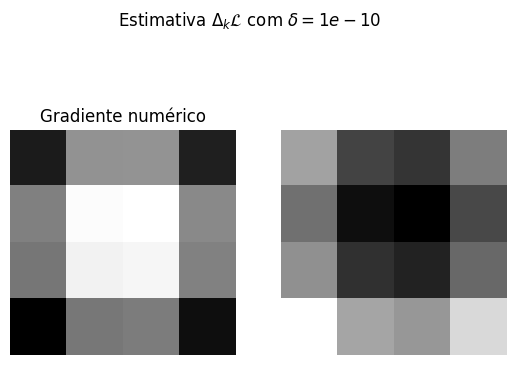

eps = 1e-09
diferença entre vetores p/ eps=1e-09: 0.8427226976163075
alinhamento: 0.15727730238391904
grad numérico:  max = 0.250314528699953, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


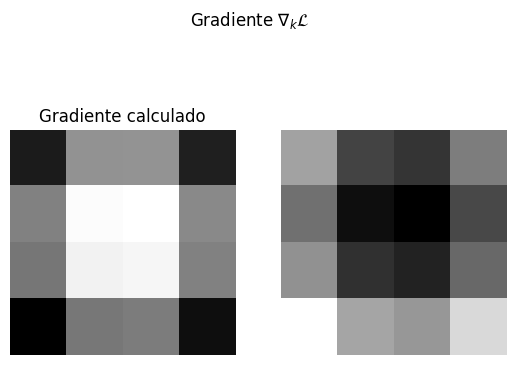

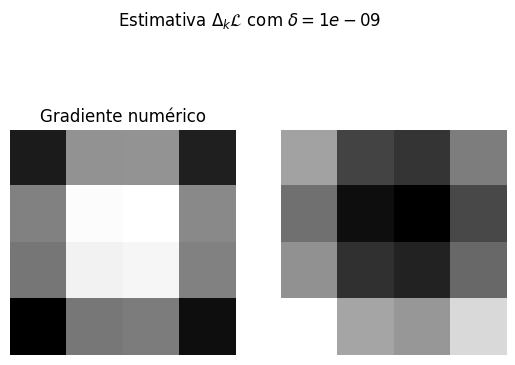

eps = 1e-08
diferença entre vetores p/ eps=1e-08: 0.8427226976151841
alinhamento: 0.15727730238486567
grad numérico:  max = 0.25031459250110966, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


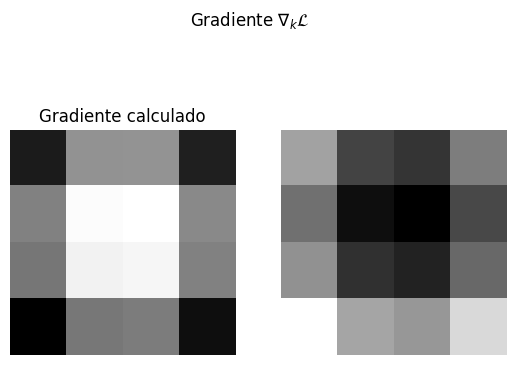

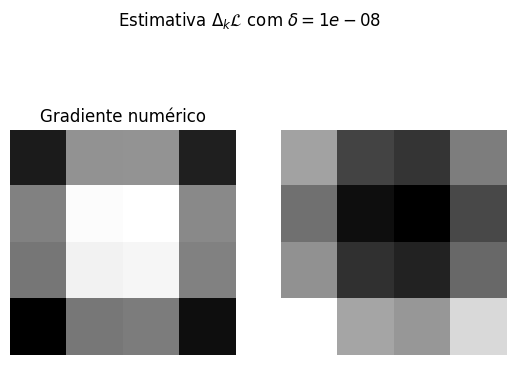

eps = 1e-07
diferença entre vetores p/ eps=1e-07: 0.8427226976150515
alinhamento: 0.1572773023849774
grad numérico:  max = 0.2503146076997025, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


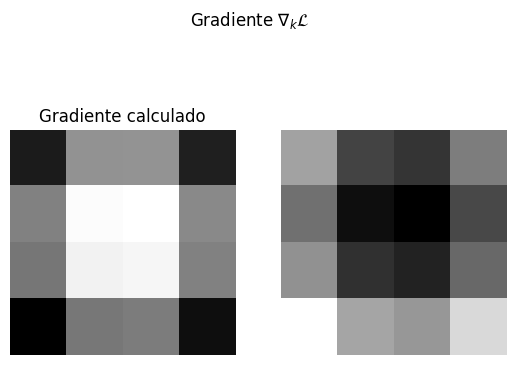

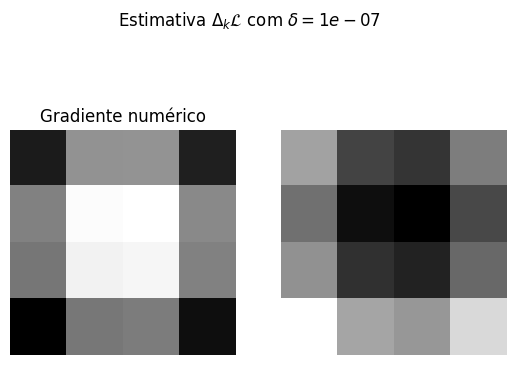

eps = 1e-06
diferença entre vetores p/ eps=1e-06: 0.842722697615053
alinhamento: 0.1572773023849762
grad numérico:  max = 0.25031460682272605, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


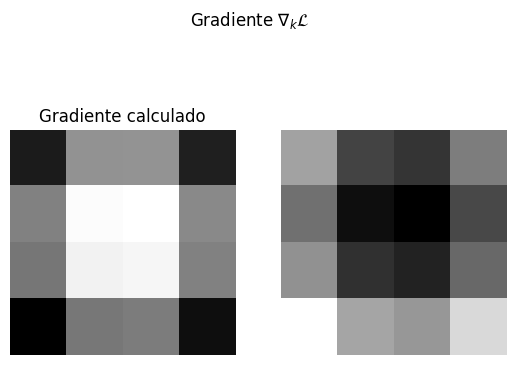

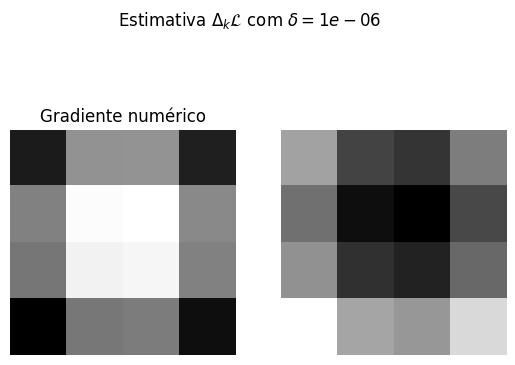

eps = 1e-05
diferença entre vetores p/ eps=1e-05: 0.8427226976150524
alinhamento: 0.1572773023849767
grad numérico:  max = 0.25031460680953027, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


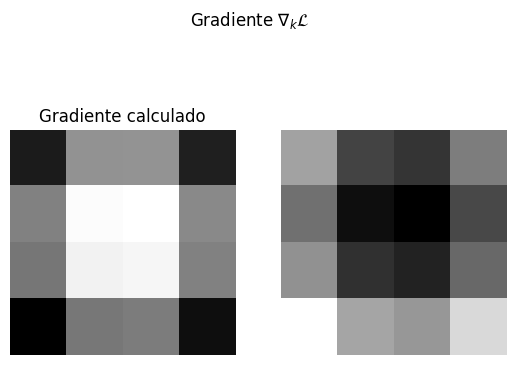

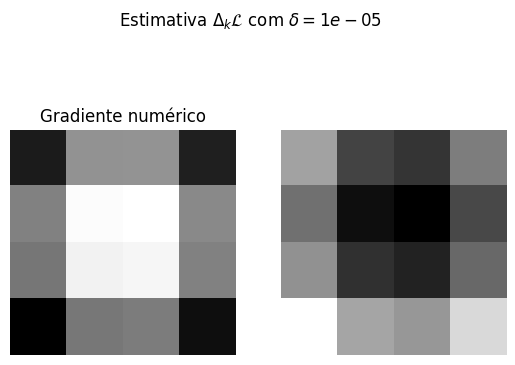

eps = 0.0001
diferença entre vetores p/ eps=0.0001: 0.8427226976150523
alinhamento: 0.1572773023849767
grad numérico:  max = 0.25031460681612716, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


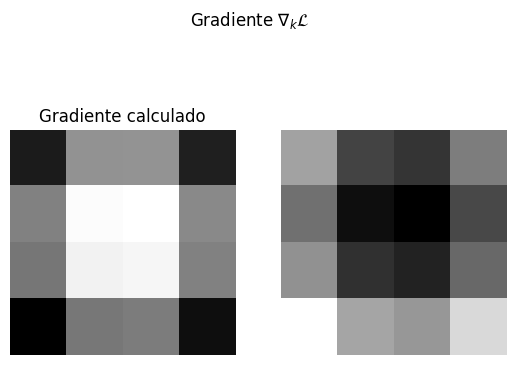

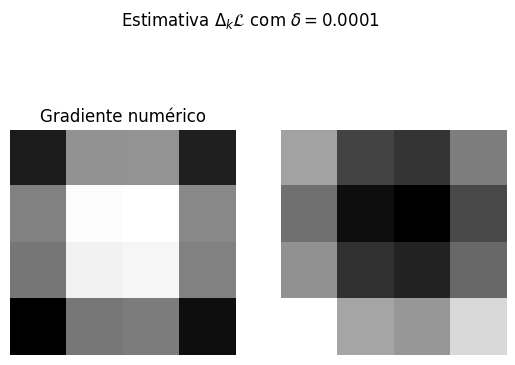

eps = 0.001
diferença entre vetores p/ eps=0.001: 0.8427226976150524
alinhamento: 0.1572773023849767
grad numérico:  max = 0.2503146068158936, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


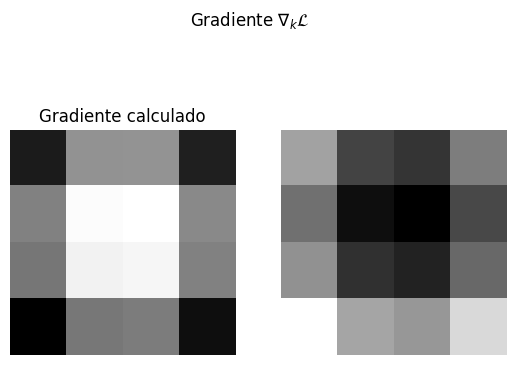

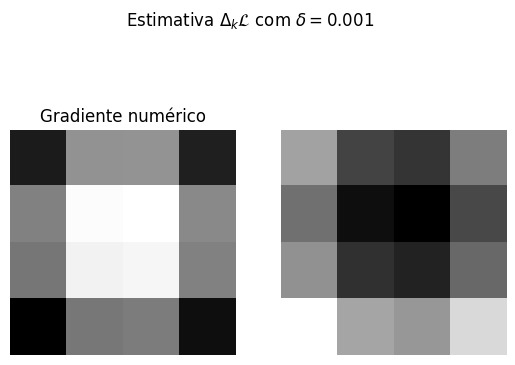

eps = 0.01
diferença entre vetores p/ eps=0.01: 0.8427226976150525
alinhamento: 0.1572773023849767
grad numérico:  max = 0.2503146068158492, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


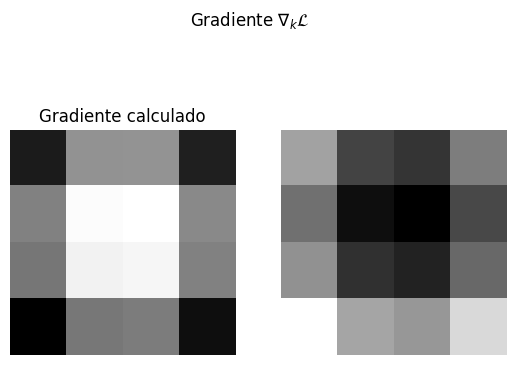

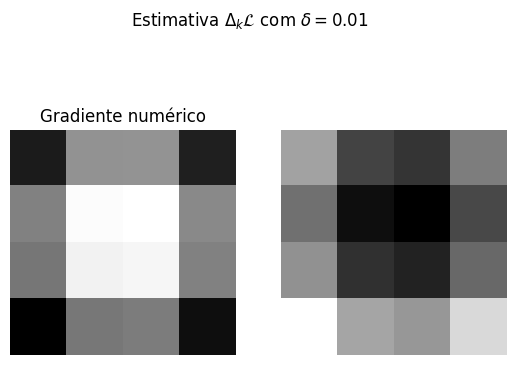

eps = 0.1
diferença entre vetores p/ eps=0.1: 0.8427226976150526
alinhamento: 0.15727730238497675
grad numérico:  max = 0.25031460681584844, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


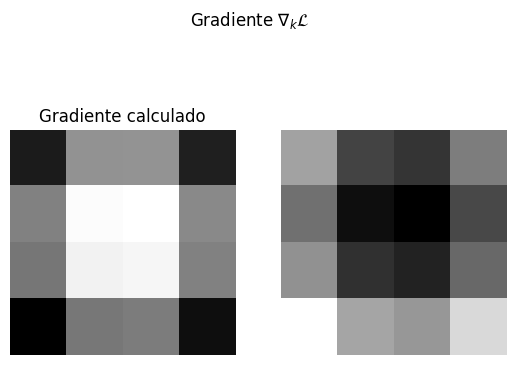

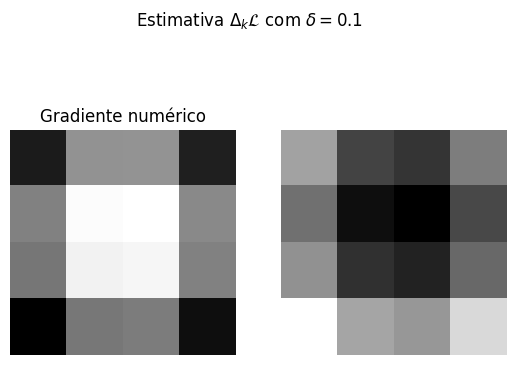

eps = 1.0
diferença entre vetores p/ eps=1.0: 0.8427226976150525
alinhamento: 0.15727730238497672
grad numérico:  max = 0.2503146068158478, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


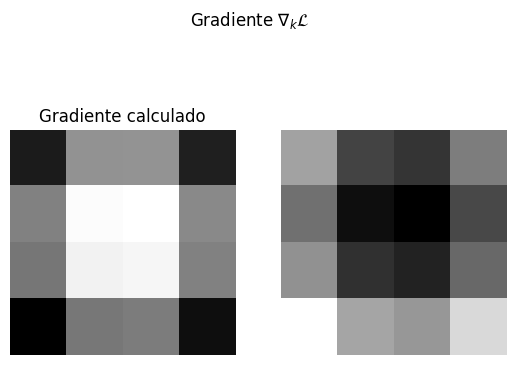

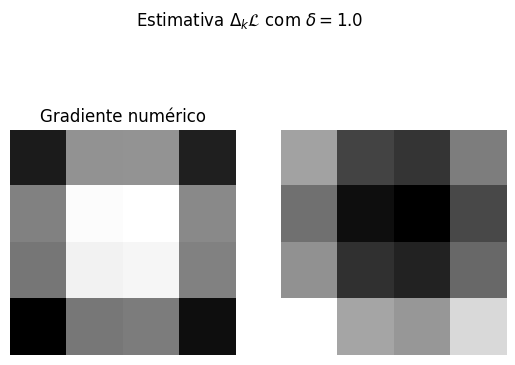

eps = 10.0
diferença entre vetores p/ eps=10.0: 0.8427226976150523
alinhamento: 0.1572773023849767
grad numérico:  max = 0.2503146068158489, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


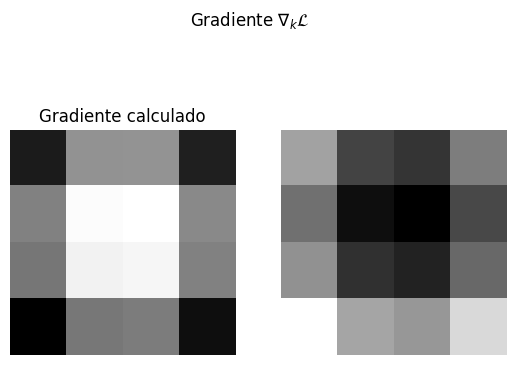

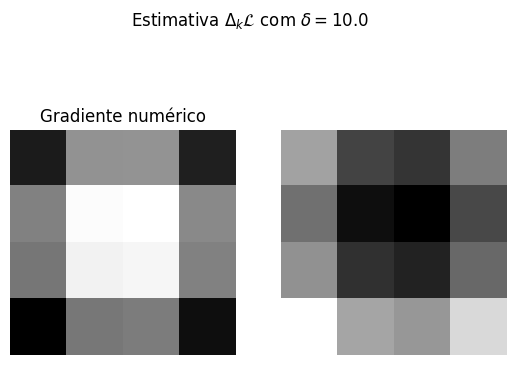

eps = 100.0
diferença entre vetores p/ eps=100.0: 0.8427226976150524
alinhamento: 0.15727730238497672
grad numérico:  max = 0.25031460681585066, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


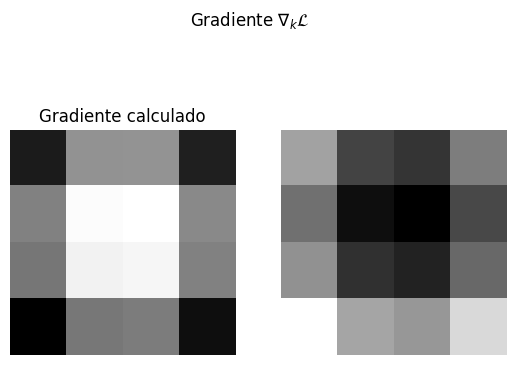

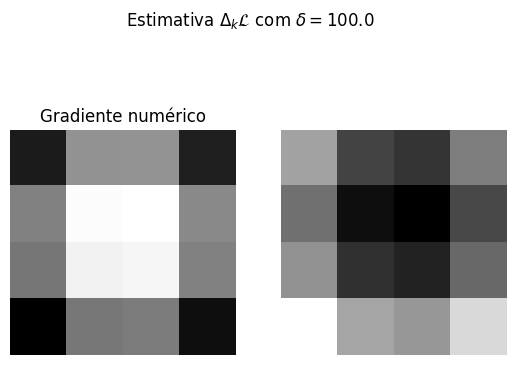

eps = 1000.0
diferença entre vetores p/ eps=1000.0: 0.8427226976150526
alinhamento: 0.15727730238497675
grad numérico:  max = 0.25031460681584383, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


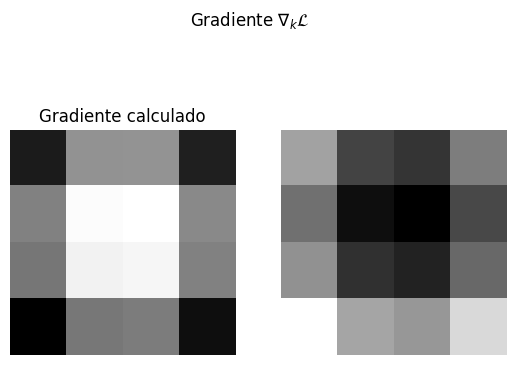

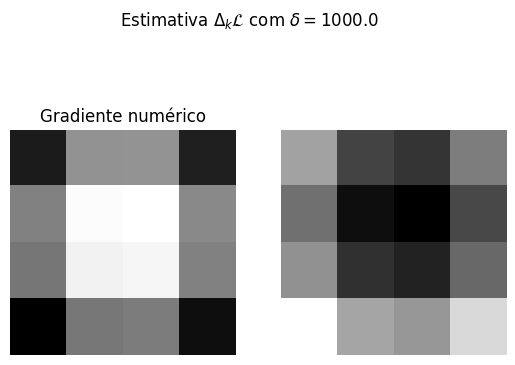

eps = 10000.0
diferença entre vetores p/ eps=10000.0: 0.8427226976150526
alinhamento: 0.15727730238497678
grad numérico:  max = 0.2503146068160434, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


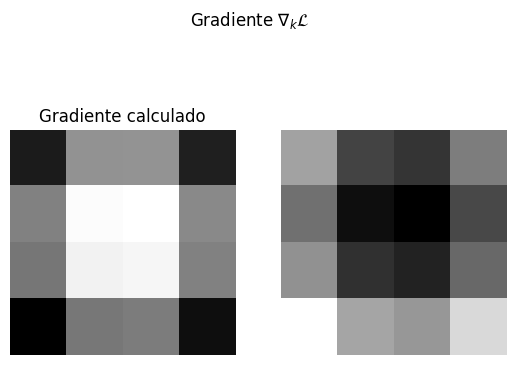

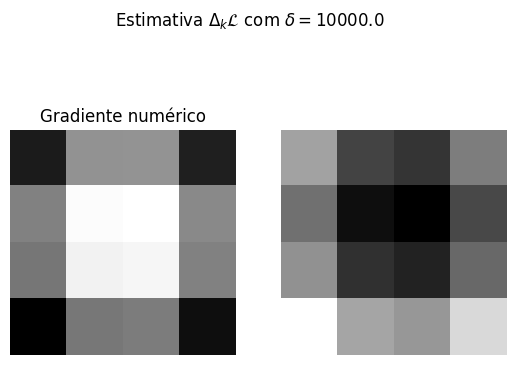

eps = 100000.0
diferença entre vetores p/ eps=100000.0: 0.8427226976150525
alinhamento: 0.15727730238497675
grad numérico:  max = 0.2503146068100727, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


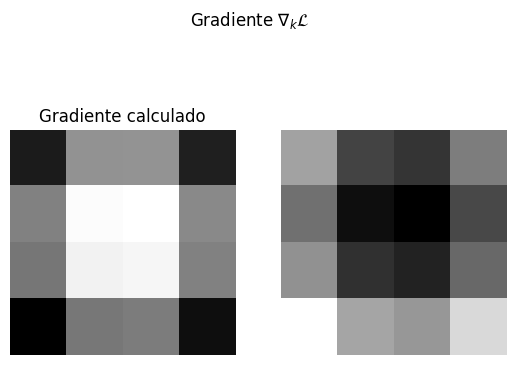

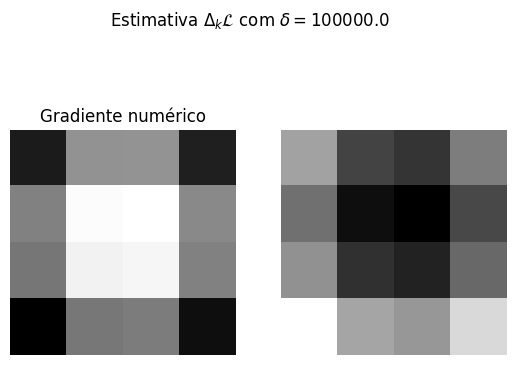

eps = 1000000.0
diferença entre vetores p/ eps=1000000.0: 0.8427226976150524
alinhamento: 0.15727730238497664
grad numérico:  max = 0.250314606753575, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


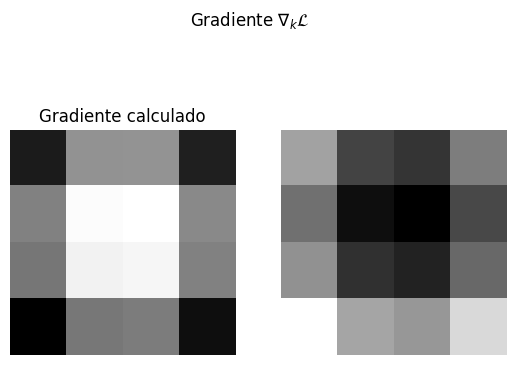

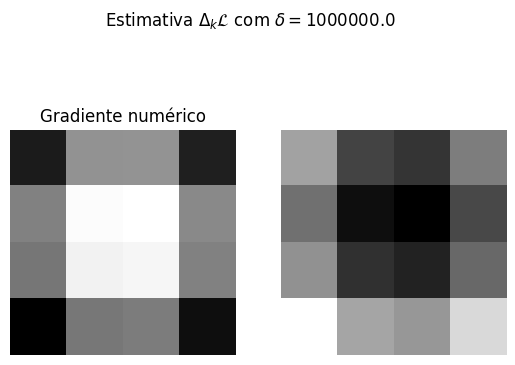

eps = 10000000.0
diferença entre vetores p/ eps=10000000.0: 0.8427226976150539
alinhamento: 0.1572773023849755
grad numérico:  max = 0.2503146066602684, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


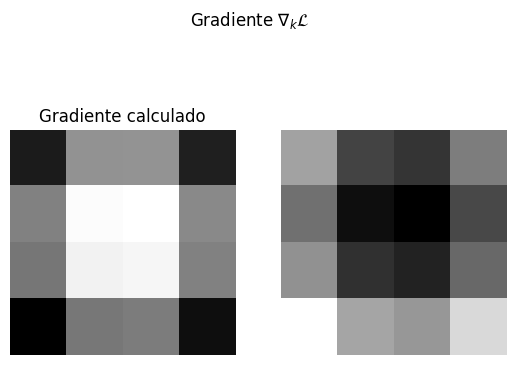

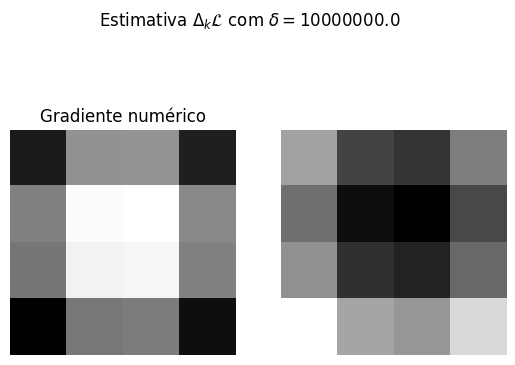

eps = 100000000.0
diferença entre vetores p/ eps=100000000.0: 0.8427226976150566
alinhamento: 0.1572773023849731
grad numérico:  max = 0.2503146143324011, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


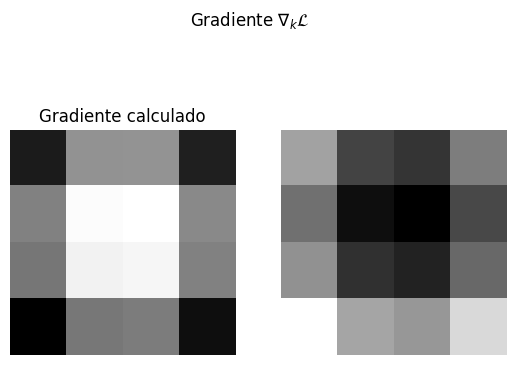

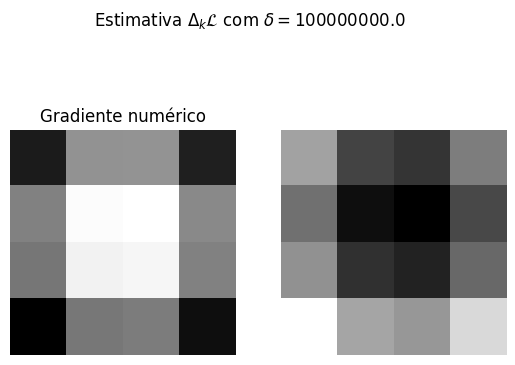

eps = 1000000000.0
diferença entre vetores p/ eps=1000000000.0: 0.8427226976152419
alinhamento: 0.15727730238481716
grad numérico:  max = 0.25031464967303074, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


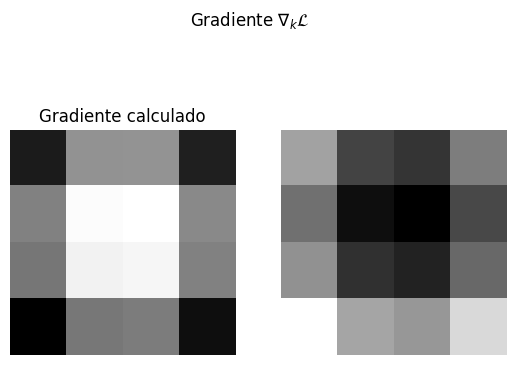

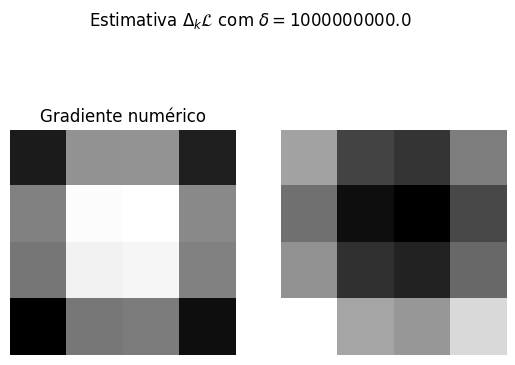

eps = 10000000000.0
diferença entre vetores p/ eps=10000000000.0: 0.842722697615611
alinhamento: 0.15727730238450596
grad numérico:  max = 0.25031483231874757, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


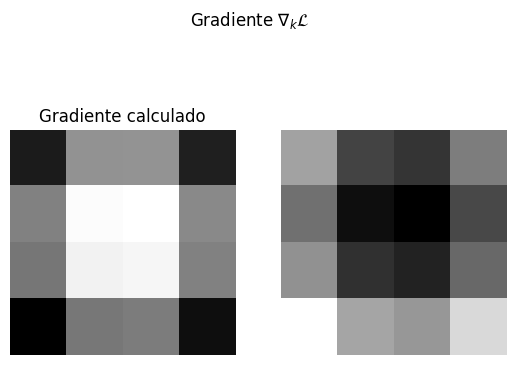

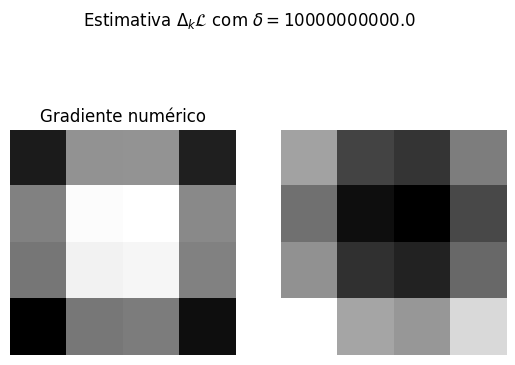

eps = 100000000000.0
diferença entre vetores p/ eps=100000000000.0: 0.842722697685328
alinhamento: 0.1572773023257538
grad numérico:  max = 0.25032268850626227, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


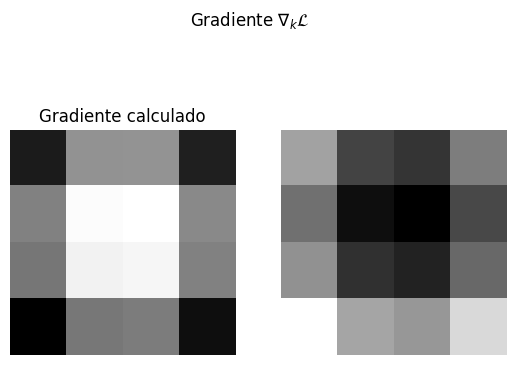

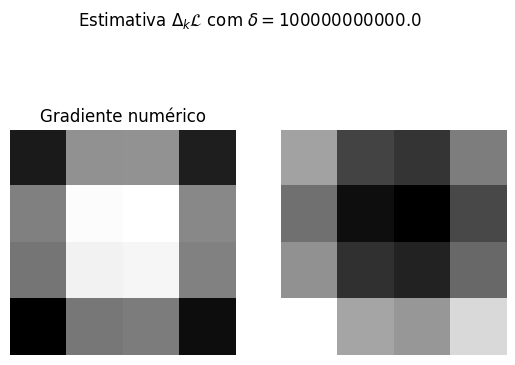

eps = 1000000000000.0
diferença entre vetores p/ eps=1000000000000.0: 0.842722712589385
alinhamento: 0.15727728976576671
grad numérico:  max = 0.25034233014404833, pos = 66
grad calculado: max = 0.03936881280044924, pos = 66


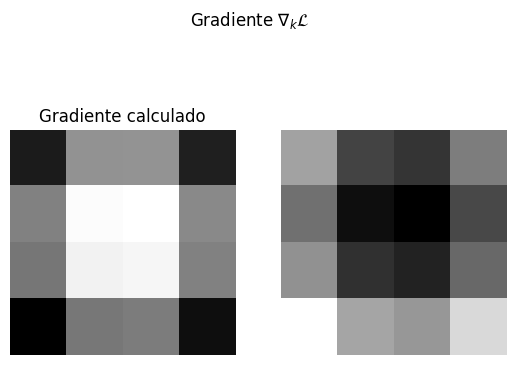

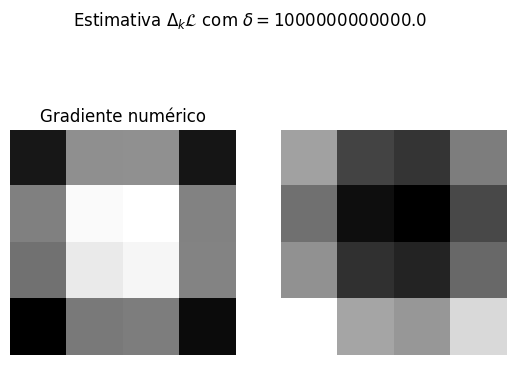

eps = 10000000000000.0
diferença entre vetores p/ eps=10000000000000.0: 0.842723426731247
alinhamento: 0.15727668794194433
grad numérico:  max = 0.25106677317308834, pos = 128
grad calculado: max = 0.03936881280044924, pos = 66


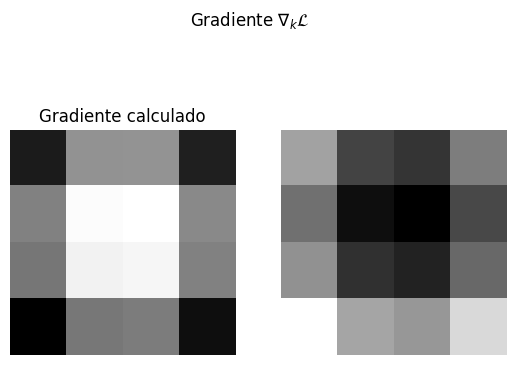

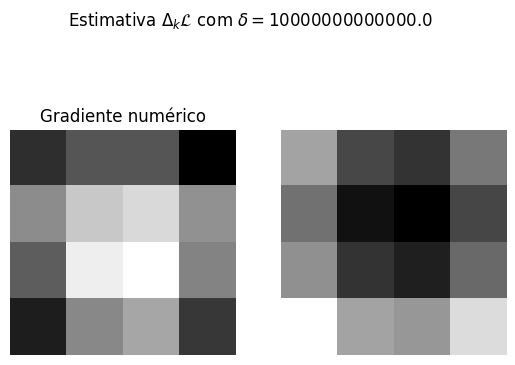

eps = 100000000000000.0
diferença entre vetores p/ eps=100000000000000.0: 0.8427424460206848
alinhamento: 0.15726065976030884
grad numérico:  max = 0.25555797142218234, pos = 126
grad calculado: max = 0.03936881280044924, pos = 66


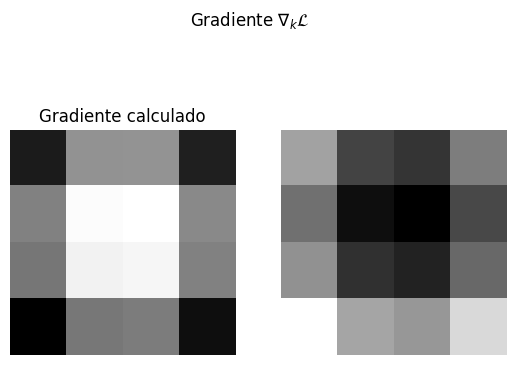

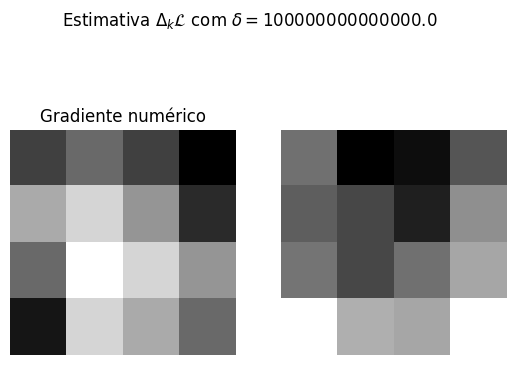

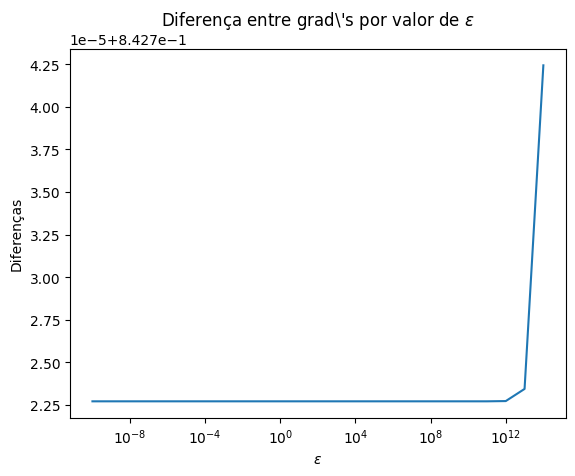

In [57]:
# Gera gradiente calculado por função
Jac_calc    = cost_fun_jac(BIMG, KER_point)

# Normaliza o gradiente (para fins de comparação da direção)
Jac_calc   /= np.linalg.norm(Jac_calc)
for ii in range(n):
    #Jac_calc[:, :, ii] /= np.max(Jac_calc[:, :, ii])
    # Zera termos irrelevantes
    Jac_calc[:, sk:, ii] = 0
    Jac_calc[sk:, :, ii] = 0

# Declaração do vetor de respostas numéricas
Jac_num_vec = [np.zeros_like(Jac_calc)] * len(eps_vec)
dif_vec     = np.zeros(len(eps_vec))

# Laço de avaliação para cada valor de eps (diferença deve cair para eps pequeno)
for ii, eps in enumerate(eps_vec):
    Jac_num_vec[ii]  = np.real(central_dif(BIMG, KER_point, IM, sk, sx, sy, n, epsi=eps))

    # Normalização do gradiente
    Jac_num_vec[ii][sk:, sk:, :] = 0
    Jac_num_vec[ii]             /= np.linalg.norm(Jac_num_vec[ii])
    #for jj in range(n):
    #    Jac_num_vec[ii][:, :, jj] /= Jac_num_vec[ii][:, :, jj].sum().sum()

    # Cálculo e impressão de métricas por iteração
    print(f'eps = {eps}')
    dif_vec[ii] = np.linalg.norm(Jac_num_vec[ii][:sk, :sk, :] - Jac_calc[:sk, :sk, :])
    print(f'diferença entre vetores p/ eps={eps}: {dif_vec[ii]}')
    print(f'alinhamento: {np.dot(Jac_num_vec[ii].ravel(), Jac_calc.ravel())}')
    print(f'grad numérico:  max = {np.max(Jac_num_vec[ii])}, pos = {np.argmax(Jac_num_vec[ii])}')
    print(f'grad calculado: max = {np.max(Jac_calc)}, pos = {np.argmax(Jac_calc)}')

    # Plotagem das var's de interesse
    # Grad calculado
    fig2 = plt.figure()
    fig2.suptitle(r'Gradiente $\nabla_{k} \mathcal{L}$')
    plt.subplot(121)
    plt.imshow(Jac_calc[:sk, :sk, 0], cmap='gray')
    plt.axis('off')
    plt.title('Gradiente calculado')
    plt.subplot(122)
    plt.imshow(Jac_calc[:sk, :sk, 1], cmap='gray')
    plt.axis('off')
    plt.show()
    # Grad numérico
    fig1 = plt.figure()
    fig1.suptitle(r'Estimativa $\Delta_k \mathcal{L}$' + r' com $\delta = {}$'.format(eps))
    plt.subplot(121)
    plt.imshow(Jac_num_vec[ii][:sk, :sk, 0], cmap='gray')
    plt.axis('off')
    plt.title('Gradiente numérico')
    plt.subplot(122)
    plt.imshow(Jac_num_vec[ii][:sk, :sk, 1], cmap='gray')
    plt.axis('off')
    plt.show()

# PLotagem dos valores de erro para cada valor de eps
#   Se o gradiente estiver certo, a diferença entre os gra-
#   dientes deve diminuir junto do eps. --> PODE SER QUE
#   HAJA AMBIGUIDADE COM DIREÇÕES NEGATIVAS!!!
plt.semilogx(eps_vec, dif_vec)
plt.ylabel('Diferenças')
plt.xlabel(r'$\delta$')
plt.title(r'Diferença entre grad\'s por valor de $\delta$')
plt.show()